In [1]:
#general import
import json 
import time
import requests
import numpy as np
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from jupyter_ui_poll import ui_events
from IPython.display import display, Image, clear_output, HTML

%matplotlib widget

In [2]:
#define the function to draw cubes 
def draw_cubes(cubes, ticks=False, grid=True, view='', flip='', rot=0, ax3d=None):
    """
    Draws a 3D plot of cubes.
    This function creates a 3D visualization of cubes based on the input array, with options to further specify the building. 

    Parameters:
    -----------
    cubes: numpy.ndarray
        An array representing a cube's position and color.
    ticks: bool
        Boolean indicating whether to display axis ticks. Default is False.
        tick = "True" returns a grid with numbered coordinates. 
        tick = "False" returns a grid without numbered coordinates.
    grid: bool
        Boolean indicating whether to display the grid. Default is True.
        grid = "True" returns cubes built on lined grids. 
        grid = "False" grid returns cubes built on lined grids. 
    view: str
        String specifying the initial view of the plot.
        view = "xy" retunrs the front view of the cubes. 
        view = "-xy" retunrs the mirror image of top view of the cubes. 
        view = "xz" retunrs the front view of the cubes. 
        view = "-xz" retunrs the mirror image of front view of the cubes. 
        view = "yz" retunrs the right view of the cubes. 
        view = "-yz" retunrs the mirror image of right view of the cubes. 
    flip: str
        String specifying axis along which to mirror the plot ('x', 'y', 'z').
        flip = "x" returns the mirror image with respect to x-axis as axis of symmetry.
        flip = "y" returns the mirror image with respect to y-axis as axis of symmetry.
        flip = "z" returns the mirror image with respect to z-axis as axis of symmetry.
    rot: int
        The cubes rotates around its vertical central axis by a set angle (in degree) clockwise. 
    ax3d: class
        An existing matplotlib 3D axis object to draw the cubes on. If None, a new figure and axis are created.
    
    Returns:
    -------
    Displays a 3D plot of the cubes.
            
    Raises
    ------
    ValueError
          If the parameter "ax3d" is empty.
          matplotlib should be installed and loaded.
          
    """
    
    # create empty cube
    cubes_to_draw = np.zeros(cubes.shape)
    
    # set elements to 1 where colour is not empty
    cubes_to_draw[cubes!=''] = 1

    # make figure and 3d axes for plotting
    if ax3d is None:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d', proj_type='ortho', box_aspect=(4,4,4))
    else:
        ax = ax3d
        
    nx, ny, nz = cubes.shape

    ax.axes.set_xlim3d(0, nx) 
    ax.axes.set_ylim3d(0, ny) 
    ax.axes.set_zlim3d(0, nz) 

    # The cubes can be plotted using a 3D voxels plot
    ax.voxels(cubes_to_draw, facecolors=cubes, edgecolors='k', shade=False);

    # view argument allows users to set a 2D projection
    if view == 'xy': ax.view_init(90, -90, 0+rot)
    elif view == '-xy': ax.view_init(-90, 90, 0-rot)
    elif view == 'xz': ax.view_init(0, -90, 0+rot)
    elif view == '-xz': ax.view_init(0, 90, 0-rot)
    elif view == 'yz': ax.view_init(0, 0, 0+rot)
    elif view == '-yz': ax.view_init(0, 180, 0-rot)
    else:   ax.view_init(azim=ax.azim+rot)

    # flip argument allows user to show a mirror image
    # flip='x' reverses image in x direction etc.
    if 'x' in flip: ax.axes.set_xlim3d(nx, 0) 
    if 'y' in flip: ax.axes.set_ylim3d(ny, 0) 
    if 'z' in flip: ax.axes.set_zlim3d(nz, 0) 

    # style figure ticks and grid lines
    if ticks==False: 
        for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
            axis.set_ticklabels([])
            axis.line.set_linestyle('')
            axis._axinfo['tick']['inward_factor'] = 0.0
            axis._axinfo['tick']['outward_factor'] = 0.0
            
    if grid==False and ticks==False: ax.set_axis_off()
    
    if ax3d is not None:
        # return axes with result
        return
    else:
        # show image
        display(fig)

        # delete figure
        plt.close(fig)

    return 

In [3]:
#define the send_to_google_form function 
def send_to_google_form(data_dict, form_url):
    ''' 
    Uploads data to a Google Form.
    This function takes a dictionary of data and a Google Form URL, then submits the data to the form. 
    
    Parameters
    ----------
    data_dict : dict
        A dictionary contains the data to be submitted for those fields.
    form_url : str
        The URL of the Google Form where data is to be submitted.
    
    Returns
    -------
    bool
        Returns True if the data was successfully submitted (HTTP response OK), False otherwise. 
    
    '''
    form_id = form_url[34:90]
    view_form_url = f'https://docs.google.com/forms/d/e/{form_id}/viewform'
    post_form_url = f'https://docs.google.com/forms/d/e/{form_id}/formResponse'

    page = requests.get(view_form_url)
    content = BeautifulSoup(page.content, "html.parser").find('script', type='text/javascript')
    content = content.text[27:-1]
    result = json.loads(content)[1][1]
    form_dict = {}
    
    loaded_all = True
    for item in result:
        if item[1] not in data_dict:
            print(f"Form item {item[1]} not found. Data not uploaded.")
            loaded_all = False
            return False
        form_dict[f'entry.{item[4][0][0]}'] = data_dict[item[1]]
        
    
    post_result = requests.post(post_form_url, data=form_dict)
    return post_result.ok

In [4]:
#define the buttons
event_info = {
    'type': '',
    'description': '',
    'time': -1
}

def wait_for_event(timeout=-1, interval=0.001, max_rate=20, allow_interupt=True):    
    """
    Waits for an event to occur within a specified timeout, with defined intervals.
    It allows for the specification of a timeout to limit the wait period and can be configured to allow interruptions based on incoming events.

    Parameters
    ----------
    timeout : float
        The maximum time to wait for in seconds. Default is -1 indicating no timeout.
    interval : float, optional
        The time interval between checks for events. Default is 0.001 seconds.
    max_rate : int
        The maximum number of events to process within each interval. Default is 20.
    allow_interrupt : bool
        "True" returens immediately when an event occurs. 
        "False" will return after timeout. 
        Default is True.

    Returns
    -------
    dict
        A dictionary containing information about the event that occurred. The dictionary contains default values if no event occurs:
        - 'type': The type of the event (empty string if no event).
        - 'description': A description of the event (empty string if no event).
        - 'time': The time the event occurred (-1 if no event).

    
    """
    start_wait = time.time()

    # set event info to be empty
    # as this is dict we can change entries
    # directly without using
    # the global keyword
    event_info['type'] = ""
    event_info['description'] = ""
    event_info['time'] = -1

    n_proc = int(max_rate*interval)+1
    
    with ui_events() as ui_poll:
        keep_looping = True
        while keep_looping==True:
            # process UI events
            ui_poll(n_proc)

            # end loop if we have waited more than the timeout period
            if (timeout != -1) and (time.time() > start_wait + timeout):
                keep_looping = False
                
            # end loop if event has occured
            if allow_interupt==True and event_info['description']!="":
                keep_looping = False
                
            # add pause before looping
            # to check events again
            time.sleep(interval)
    
    # return event description after wait ends
    # will be set to empty string '' if no event occured
    return event_info

# this function lets buttons 
# register events when clicked

In [5]:
def register_event(btn):
    """
    Waits for an event to occur within a specified timeout, polling at defined intervals.

    This function listens for UI events, updating a global `event_info` dictionary with the event's type, description, and time when an event occurs. It allows for the specification of a timeout to limit the wait period and can be configured to allow interruptions based on incoming events.

    Parameters
    ----------
    timeout : float, optional
        The maximum time to wait for an event in seconds. A negative value indicates no timeout. Default is -1.
    interval : float, optional
        The time interval in seconds between checks for UI events. Default is 0.001 seconds.
    max_rate : int, optional
        The maximum number of events to process within each interval. Default is 20.
    allow_interrupt : bool, optional
        If True, the function will return immediately when an event occurs. If False, it waits until the timeout expires. Default is True.

    Returns
    -------
    dict
        A dictionary containing information about the event that occurred. If no event occurs within the timeout period, the dictionary will contain default values indicating no event:
        - 'type': The type of the event (empty string if no event).
        - 'description': A description of the event (empty string if no event).
        - 'time': The time the event occurred (-1 if no event).

    Notes
    -----
    This function uses a global dictionary `event_info` to store and return event information. It is designed to be used within environments that support UI events and requires access to specific UI polling functions (`ui_events` in this context) to function correctly.
    
    
    """
    # display button description in output area
    event_info['type'] = "click"
    event_info['description'] = btn.description
    event_info['time'] = time.time()
    return

In [6]:
# Welcome
print("Welcome to the Spatial Resoning Test (SRT).")
print("Please enter your group number, age, gender and anonymised ID to continue the test.")
time.sleep(2)

#user input user id
id_instructions = """
Please enter your anonymised ID (4 letters)

To generate an anonymous 4-letter unique user identifier please enter:
- two letters based on the initials (first and last name) of a childhood friend
- two letters based on the initials (first and last name) of a favourite actor / actress

e.g. if your friend was called Charlie Brown and film star was Tom Cruise
     then your unique identifier would be CBTC
"""
print(id_instructions)


user_id = input (">")

#collect group number
print("Please enter your group Number.")
group_number = input('>')
time.sleep(1)

#user input age
print("Please enter your age.")
age = input (">")
time.sleep(1)


#enter gender
print("Please enter your physiological gender.")
gender = input(">")
time.sleep(1)

Welcome to the Spatial Resoning Test (SRT).
Please enter your group number, age, gender and anonymised ID to continue the test.

Please enter your anonymised ID (4 letters)

To generate an anonymous 4-letter unique user identifier please enter:
- two letters based on the initials (first and last name) of a childhood friend
- two letters based on the initials (first and last name) of a favourite actor / actress

e.g. if your friend was called Charlie Brown and film star was Tom Cruise
     then your unique identifier would be CBTC



> id


Please enter your group Number.


> id


Please enter your age.


> id


Please enter your physiological gender.


> male


In [7]:
#data consent
myhtml_data1 = HTML("<h1>DATA CONSENT INFORMATION:</h1>")
display(myhtml_data1)

data_consent_info = """
Please read:

We wish to record your response data
to an anonymised public data repository. 
Your data will be used for educational teaching purposes
practising data analysis and visualisation."""
print(data_consent_info)

myhtml_data1 = HTML('<h3>Please type   "yes"   in the box below if you consent to the upload.</h3>')
display(myhtml_data1)

result = input("> ") 

if result == "yes": 
    print("Thanks for your participation.")
    print("Please contact a.fedorec@ucl.ac.uk")
    print("If you have any questions or concerns")
    print("regarding the stored results.")
    
else: 
    # end code execution by raising an exception
    raise(Exception("User did not consent to continue test."))
    
time.sleep(2)
clear_output()

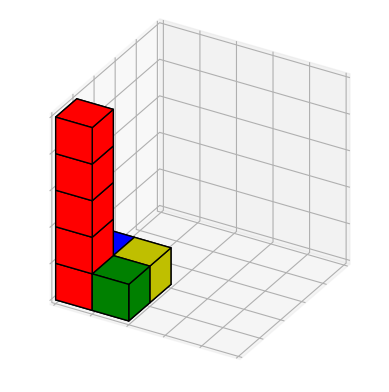

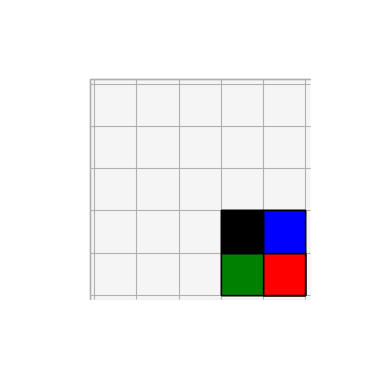

A


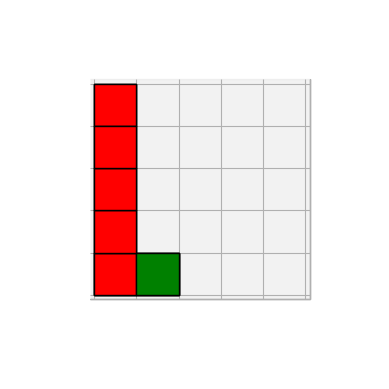

B


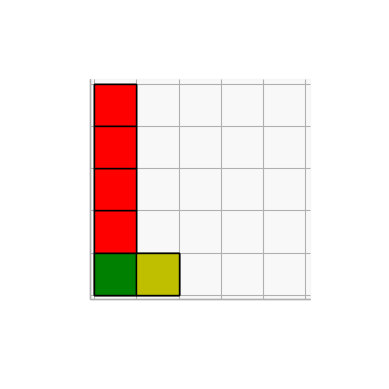

C


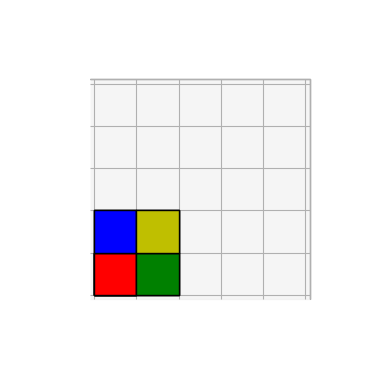

D


In [ ]:
#Question 1

#Scoring System 
score = 0

#Welcome
myhtml_11 = HTML("<h1>Spatial Resoning Test (SRT) Question 1</h1>")
display(myhtml_11)
time.sleep(1)
myhtml_x2 = HTML("<h2>Please observe the following 3D cubes and the 2D projections.</h2>")
display(myhtml_x2)
time.sleep(1)

# Q1 cubes drawing

# define a 5 x 5 x 5 cube space

# to draw a cube in the space
# we set the entry to a colour

# allowed colours:
#
# r - red,     g - green, b - blue, 
# m - magenta, c - cyan,  y - yellow
# k - black,   w - white

# define 3d 5x5x5 string array with entries set to '' 
cubes1 = np.full((5,5,5),'')

# construct cube arrangement 
# by inserting color codes into 3D array

# specify colours for specific cubes
cubes1[0,0,0:5] = 'r' 
cubes1[1,0,0] = 'g'
cubes1[0,1,0] = 'b'
cubes1[1,1,0] = 'y'

# draw the result
draw_cubes(cubes1)

#q1 false cube
cubes1f = np.full((5,5,5),'')
cubes1f[0,0,0:5] = 'r' 
cubes1f[1,0,0] = 'g'
cubes1f[0,1,0] = 'b'
cubes1f[1,1,0] = 'k'


#draw projections
draw_cubes(cubes1f, view='-xy')# draw the view from bottom in XY plane
print ("A")
draw_cubes(cubes1, view='xz')# draw the side view in XZ direction
print ("B")
draw_cubes(cubes1, view='yz')# draw the side view in YZ direction
print ("C")
draw_cubes(cubes1, flip='z', view='xy')# display the projection obtained from the flipped arrangement.
print ("D")
start_time_q1=time.time()

#buttons 
myhtml_x3 = HTML("<h2>Please choose the 2D projection that CANNOT be obtained by rotating the 3D cubes in space.</h2>")
display(myhtml_x3)

btnA = widgets.Button(description="A")
btnB = widgets.Button(description="B")
btnC = widgets.Button(description="C")
btnD = widgets.Button(description="D")

btnA.on_click(register_event) 
btnB.on_click(register_event) 
btnC.on_click(register_event) 
btnD.on_click(register_event) 

panel = widgets.HBox([btnA, btnB, btnC, btnD])
display (panel)

result = wait_for_event()
clear_output()

#interaction with user 
myhtml_x4 = HTML("<h2>Correct!</h2>")
myhtml_15 = HTML("<h2>Sorry! The correct answer is A.</h2>")

    
if result['description']=="A":
    display (myhtml_x4)
    score = score + 1 
    q1_mark = 1
else:
    display (myhtml_15)
    q1_mark = 0

#save answer
if result['description']=="A":
    q1_ans="A"
elif result['description']=="B":
    q1_ans="B"
elif result['description']=="C":
    q1_ans="C"
elif result['description']=="D":
    q1_ans="D"

#time used
end_time_q1=time.time()
time_taken_q1=end_time_q1 - start_time_q1
print (f"You took {time_taken_q1:.2f} seconds.")
time.sleep(2)
clear_output()

In [ ]:
#Question 2

#Welcome
myhtml_21 = HTML("<h1>Spatial Resoning Test (SRT) Question 2</h1>")
display(myhtml_21)
time.sleep(1)
display(myhtml_x2)
time.sleep(1)


#Q2 cubes drawing
# define 3d 5x5x5 string array with entries set to '' 
cubes2 = np.full((5,5,5),'')

# construct cube arrangement 
# by inserting color codes into 3D array

# specify colours for specific cubes
cubes2[0:3,0,0] = 'r' #  use slice indexing to fill blocks x=0,1,2        y=0  z=0 
cubes2[0:6,1,0] = 'g' #  use slice indexing to fill blocks x=0,1,2,3,4,5  y=0  z=0 

# draw the result
draw_cubes(cubes2)

#q2 false cube
cubes2f = np.full((5,5,5),'')
cubes2f[0:2,0,0] = 'r'
cubes2f[0:6,1,0] = 'g'

#draw projections
draw_cubes(cubes2, view='xy')# draw the view from bottom in XY plane
print("A")
draw_cubes(cubes2f, flip='x', view='xz')# display the projection obtained from the flipped arrangement.
print("B")
draw_cubes(cubes2, view='-xy')# draw the side view in -xy direction
print("C")
draw_cubes(cubes2, view='yz')# draw the side view in YZ direction
print("D")
start_time_q2=time.time()

#buttons 
display(myhtml_x3)

btnA = widgets.Button(description="A")
btnB = widgets.Button(description="B")
btnC = widgets.Button(description="C")
btnD = widgets.Button(description="D")

btnA.on_click(register_event) 
btnB.on_click(register_event) 
btnC.on_click(register_event) 
btnD.on_click(register_event) 

panel = widgets.HBox([btnA, btnB, btnC, btnD])
display (panel)

result = wait_for_event()
clear_output()

#interaction with user 
myhtml_15 = HTML("<h2>Sorry! The correct answer is B.</h2>")
 
if result['description']=="B":
    display (myhtml_x4)
    score = score + 1 
    q2_mark = 1
else:
    display (myhtml_15)
    q2_mark = 0

#save answer
if result['description']=="A":
    q2_ans="A"
elif result['description']=="B":
    q2_ans="B"
elif result['description']=="C":
    q2_ans="C"
elif result['description']=="D":
    q2_ans="D"


end_time_q2=time.time()
time_taken_q2=end_time_q2 - start_time_q2
print (f"You took {time_taken_q2:.2f} seconds.")
time.sleep(2)
clear_output()

In [ ]:
#Question 3

#Welcome
myhtml_31 = HTML("<h1>Spatial Resoning Test (SRT) Question 3</h1>")
display(myhtml_31)
time.sleep(1)
display(myhtml_x2)
time.sleep(1)


# Q3 cubes drawing

# define 3d 5x5x5 string array with entries set to '' 
cubes3 = np.full((5,5,5),'')

# construct cube arrangement 
# by inserting color codes into 3D array

cubes3[0:3,0,0] = 'r' 
cubes3[3,1:3,0] = 'g' 
cubes3[1:3,1:3,0:2] = 'b' 
cubes3[3,0,0] = 'm'
cubes3[1,2,2] = 'y'

# draw the result
draw_cubes(cubes3)

#q3 false cubes
cubes3f = np.full((5,5,5),'')
cubes3f[0:3,0,0] = 'r' 
cubes3f[3,1:3,0] = 'g' 
cubes3f[1:3,1:3,0:2] = 'b' 
cubes3f[3:4,0,0] = 'm'
cubes3f[1,1,2] = 'y'

#draw projections
draw_cubes(cubes3, view='xz')# draw the side view in XZ direction
print("A")
draw_cubes(cubes3, view='yz')# draw the side view in YZ direction
print("B")
draw_cubes(cubes3f, view='-yz')# draw the side view in -YZ direction (other side)
print("C")
draw_cubes(cubes3, view='-xy')# draw the view from bottom in XY plane
print("D")
start_time_q3=time.time()

#buttons 
display(myhtml_x3)

btnA = widgets.Button(description="A")
btnB = widgets.Button(description="B")
btnC = widgets.Button(description="C")
btnD = widgets.Button(description="D")

btnA.on_click(register_event) 
btnB.on_click(register_event) 
btnC.on_click(register_event) 
btnD.on_click(register_event) 

panel = widgets.HBox([btnA, btnB, btnC, btnD])
display (panel)

result = wait_for_event()
clear_output()

#interaction with user 
myhtml_35 = HTML("<h2>Sorry! The correct answer is C.</h2>")
 
if result['description']=="C":
    display (myhtml_x4)
    score = score + 1 
    q3_mark = 1
else:
    display (myhtml_35)
    q3_mark = 0

    
#save answer
if result['description']=="A":
    q3_ans="A"
elif result['description']=="B":
    q3_ans="B"
elif result['description']=="C":
    q3_ans="C"
elif result['description']=="D":
    q3_ans="D"

end_time_q3=time.time()
time_taken_q3=end_time_q3 - start_time_q3
print (f"You took {time_taken_q3:.2f} seconds.")
time.sleep(2)
clear_output()

In [ ]:
#Question 4

#Welcome
myhtml_41 = HTML("<h1>Spatial Resoning Test (SRT) Question 4</h1>")
display(myhtml_41)
time.sleep(1)
display(myhtml_x2)
time.sleep(1)

# Q4 cubes drawing
cubes4= np.full((5,5,5),'')
#inserting coulours
cubes4[1:4,2,3] = 'r' 
cubes4[0,3,4] = 'g' 
cubes4[3:4,1:3,3] = 'b' 
cubes4[3,0,0] = 'm'
cubes4[4,3,3] = 'y'

# draw the result
draw_cubes(cubes4)

#q4 false cubes
cubes4f= np.full((5,5,5),'')
cubes4f[1:4,2,3] = 'r' 
cubes4f[0,3,4] = 'g' 
cubes4f[3:4,1:3,3] = 'b' 
cubes4f[3,1,1] = 'm'
cubes4f[4,3,3] = 'y'

#draw projections
draw_cubes(cubes4, view='-xy')# draw the view from bottom in XY plane
print("A")
draw_cubes(cubes4f, view='-yz')# draw the side view in -YZ direction (other side)
print("B")
draw_cubes(cubes4, view='xz')# draw the side view in XZ direction
print("C")
draw_cubes(cubes4, view='yz')# draw the side view in YZ direction
print("D")
start_time_q4=time.time()

#buttons 
display(myhtml_x3)

btnA = widgets.Button(description="A")
btnB = widgets.Button(description="B")
btnC = widgets.Button(description="C")
btnD = widgets.Button(description="D")

btnA.on_click(register_event) 
btnB.on_click(register_event) 
btnC.on_click(register_event) 
btnD.on_click(register_event) 

panel = widgets.HBox([btnA, btnB, btnC, btnD])
display (panel)

result = wait_for_event()
clear_output()

#interaction with user 
myhtml_45 = HTML("<h2>Sorry! The correct answer is B.</h2>")
 
if result['description']=="B":
    display (myhtml_x4)
    score = score + 1 
    q4_mark = 1
else:
    display (myhtml_45)
    q4_mark = 0

#save answer
if result['description']=="A":
    q4_ans="A"
elif result['description']=="B":
    q4_ans="B"
elif result['description']=="C":
    q4_ans="C"
elif result['description']=="D":
    q4_ans="D"

end_time_q4=time.time()
time_taken_q4=end_time_q4 - start_time_q4
print (f"You took {time_taken_q4:.2f} seconds.")
time.sleep(2)
clear_output()

In [ ]:
# Question 5

#Welcome
myhtml_51 = HTML("<h1>Spatial Resoning Test (SRT) Question 5</h1>")
display(myhtml_51)
time.sleep(1)
display(myhtml_x2)
time.sleep(1)

# Q5 cubes drawing
cubes5= np.full((5,5,5),'')
cubes5[4,3,2:4] = 'r' 
cubes5[2:3,0,0:2] = 'g' 
cubes5[2,1:2,2:3] = 'b' 
draw_cubes(cubes5)

#q5 false cubes
cubes5f= np.full((5,5,5),'')
cubes5f[4,3,1:4] = 'r' 
cubes5f[2:3,0,0:2] = 'g' 
cubes5f[2,1:2,2:3] = 'b' 

#draw projections
draw_cubes(cubes5f, view='-yz')
print("A")
draw_cubes(cubes5, view='xy')
print("B")
draw_cubes(cubes5, view='yz')
print("C")
draw_cubes(cubes5, view='xz')
print("D")
start_time_q5=time.time()

#buttons 
display(myhtml_x3)

btnA = widgets.Button(description="A")
btnB = widgets.Button(description="B")
btnC = widgets.Button(description="C")
btnD = widgets.Button(description="D")

btnA.on_click(register_event) 
btnB.on_click(register_event) 
btnC.on_click(register_event) 
btnD.on_click(register_event) 

panel = widgets.HBox([btnA, btnB, btnC, btnD])
display (panel)

result = wait_for_event()
clear_output()

#interaction with user 
myhtml_55 = HTML("<h2>Sorry! The correct answer is A.</h2>")
 
if result['description']=="A":
    display (myhtml_x4)
    score = score + 1 
    q5_mark = 1
else:
    display (myhtml_55)
    q5_mark = 0

#save answer
if result['description']=="A":
    q5_ans="A"
elif result['description']=="B":
    q5_ans="B"
elif result['description']=="C":
    q5_ans="C"
elif result['description']=="D":
    q5_ans="D"


end_time_q5=time.time()
time_taken_q5=end_time_q5 - start_time_q5
print (f"You took {time_taken_q5:.2f} seconds.")
time.sleep(2)
clear_output()

In [ ]:
# Question 6

#Welcome
myhtml_61 = HTML("<h1>Spatial Resoning Test (SRT) Question 6</h1>")
display(myhtml_61)
time.sleep(1)
display(myhtml_x2)
time.sleep(1)

# Q6 cubes drawing
cubes6= np.full((5,5,5),'')
cubes6[4,0:3,3] = 'r' 
cubes6[0,0:3,1] = 'g' 
cubes6[2,0:3,4] = 'b' 
cubes6[1,0:3,0] = 'y'
draw_cubes(cubes6)

# Q6 false cubes
cubes6f= np.full((5,5,5),'')
cubes6f[4,0:3,3] = 'r' 
cubes6f[0,0:3,1] = 'g' 
cubes6f[2,0:3,4] = 'b' 
cubes6f[1,0:3,0] = 'c'

#draw projections
draw_cubes(cubes6, view='xy')
print("A")
draw_cubes(cubes6, view='yz')
print("B")
draw_cubes(cubes6, view='xz')
print("C")
draw_cubes(cubes6f, view='-xz')
print("D")
start_time_q6=time.time()

#buttons 
display(myhtml_x3)

btnA = widgets.Button(description="A")
btnB = widgets.Button(description="B")
btnC = widgets.Button(description="C")
btnD = widgets.Button(description="D")

btnA.on_click(register_event) 
btnB.on_click(register_event) 
btnC.on_click(register_event) 
btnD.on_click(register_event) 

panel = widgets.HBox([btnA, btnB, btnC, btnD])
display (panel)

result = wait_for_event()
clear_output()

#interaction with user 
myhtml_65 = HTML("<h2>Sorry! The correct answer is D.</h2>")
 
if result['description']=="D":
    display (myhtml_x4)
    score = score + 1 
    q6_mark = 1
else:
    display (myhtml_65)
    q6_mark = 0
    
#save answer
if result['description']=="A":
    q6_ans="A"
elif result['description']=="B":
    q6_ans="B"
elif result['description']=="C":
    q6_ans="C"
elif result['description']=="D":
    q6_ans="D"

end_time_q6=time.time()
time_taken_q6=end_time_q6 - start_time_q6
print (f"You took {time_taken_q6:.2f} seconds.")
time.sleep(2)
clear_output()

In [ ]:
# Question 7

#Welcome
myhtml_71 = HTML("<h1>Spatial Resoning Test (SRT) Question 7</h1>")
display(myhtml_71)
time.sleep(1)
display(myhtml_x2)
time.sleep(1)

# Q7 cubes drawing
cubes7= np.full((5,5,5),'')
cubes7[1,0:4,3] = 'g' 
cubes7[2,0:4,4] = 'b' 
cubes7[3,0:4,3] = 'm'
cubes7[4,0:4,2] = 'y'
draw_cubes(cubes7)

# Q7 false cubes 
cubes7f= np.full((5,5,5),'')
cubes7f[1,0:4,3] = 'g' 
cubes7f[2,0:4,4] = 'r' 
cubes7f[3,0:4,3] = 'm'
cubes7f[4,0:4,2] = 'y'

#draw projections
draw_cubes(cubes7, view='xy')
print("A")
draw_cubes(cubes7f, view='-yz')
print("B")
draw_cubes(cubes7, view='xz')
print("C")
draw_cubes(cubes7, view='yz')
print("D")
start_time_q7=time.time()

#buttons 
display(myhtml_x3)

btnA = widgets.Button(description="A")
btnB = widgets.Button(description="B")
btnC = widgets.Button(description="C")
btnD = widgets.Button(description="D")

btnA.on_click(register_event) 
btnB.on_click(register_event) 
btnC.on_click(register_event) 
btnD.on_click(register_event) 

panel = widgets.HBox([btnA, btnB, btnC, btnD])
display (panel)

result = wait_for_event()
clear_output()

#interaction with user 
myhtml_75 = HTML("<h2>Sorry! The correct answer is B.</h2>")
 
if result['description']=="B":
    display (myhtml_x4)
    score = score + 1 
    q7_mark = 1
else:
    display (myhtml_75)
    q7_mark = 0
    
#save answer
if result['description']=="A":
    q7_ans="A"
elif result['description']=="B":
    q7_ans="B"
elif result['description']=="C":
    q7_ans="C"
elif result['description']=="D":
    q7_ans="D"

end_time_q7=time.time()
time_taken_q7=end_time_q7 - start_time_q7
print (f"You took {time_taken_q7:.2f} seconds.")
time.sleep(2)
clear_output()

In [ ]:
# Question 8

#Welcome
myhtml_81 = HTML("<h1>Spatial Resoning Test (SRT) Question 8</h1>")
display(myhtml_81)
time.sleep(1)
display(myhtml_x2)
time.sleep(1)

# Q8 cubes drawing
cubes8= np.full((5,5,5),'')
cubes8[0:2,0:4,1] = 'g' 
cubes8[0:2,0:4,3] = 'm'
cubes8[0:2,0:4,2] = 'y'
draw_cubes(cubes8)

# Q8 false cubes 
cubes8f= np.full((5,5,5),'')
cubes8f[0:2,0:3,1] = 'g' 
cubes8f[0:2,0:3,3] = 'm'
cubes8f[0:2,0:3,2] = 'y'

#draw projections
draw_cubes(cubes8f, view='-xy')
print("A")
draw_cubes(cubes8, view='xy')
print("B")
draw_cubes(cubes8, view='yz')
print("C")
draw_cubes(cubes8, view='xz')
print("D")
start_time_q8=time.time()

#buttons 
display(myhtml_x3)

btnA = widgets.Button(description="A")
btnB = widgets.Button(description="B")
btnC = widgets.Button(description="C")
btnD = widgets.Button(description="D")

btnA.on_click(register_event) 
btnB.on_click(register_event) 
btnC.on_click(register_event) 
btnD.on_click(register_event) 

panel = widgets.HBox([btnA, btnB, btnC, btnD])
display (panel)

result = wait_for_event()
clear_output()

#interaction with user 
myhtml_85 = HTML("<h2>Sorry! The correct answer is A.</h2>")
 
if result['description']=="A":
    display (myhtml_x4)
    score = score + 1 
    q8_mark = 1
else:
    display (myhtml_85)
    q8_mark = 0
    
#save answer
if result['description']=="A":
    q8_ans="A"
elif result['description']=="B":
    q8_ans="B"
elif result['description']=="C":
    q8_ans="C"
elif result['description']=="D":
    q8_ans="D"


end_time_q8=time.time()
time_taken_q8=end_time_q8 - start_time_q8
print (f"You took {time_taken_q8:.2f} seconds.")
time.sleep(2)
clear_output()

In [ ]:
#conclusion
time_taken_sum = time_taken_q1 + time_taken_q2 + time_taken_q3 + time_taken_q4 + time_taken_q5 +time_taken_q6 + time_taken_q7 + time_taken_q8
myhtml_con1 = HTML("<h1>Congratulations, you have finished the Spatial Resoning Test (SRT)!</h1>")
display(myhtml_con1)
myhtml_con2 = HTML(f"<h2>You took {time_taken_sum:.2f} seconds to answer all 8 questions.</h2>")
display(myhtml_con2)
myhtml_con3 = HTML(f"<h2>You scored {score}/8.</h2>")
display(myhtml_con3)

In [ ]:
#creating dataframe to show the overall results
overall_result = {
    'User ID': [f'{user_id}'],
    'Group Number': [f'{group_number}'],
    'Age': [f'{age}'],
    'Gender': [f'{gender}'],
    'Q1 Answer': [f'{q1_ans}'],
    'Q1 Mark': [f'{q1_mark}'],
    'Q2 Answer': [f'{q2_ans}'],
    'Q2 Mark': [f'{q2_mark}'],
    'Q3 Answer': [f'{q3_ans}'],
    'Q3 Mark': [f'{q3_mark}'],
    'Q4 Answer': [f'{q4_ans}'],
    'Q4 Mark': [f'{q4_mark}'],
    'Q5 Answer': [f'{q5_ans}'],
    'Q5 Mark': [f'{q5_mark}'],
    'Q6 Answer': [f'{q6_ans}'],
    'Q6 Mark': [f'{q6_mark}'],
    'Q7 Answer': [f'{q7_ans}'],
    'Q7 Mark': [f'{q7_mark}'],
    'Q8 Answer': [f'{q8_ans}'],
    'Q8 Mark': [f'{q8_mark}'],
    'Time (s)': [f'{time_taken_sum:.2f}'],
    'Score (out of 8)': [f'{score}'],
}

overall_result_df = pd.DataFrame(overall_result)
display (overall_result_df)

In [ ]:
#save the result in json format
test_result = {'Q1 Answer': [f'{q1_ans}'],
    'Q1 Mark': [f'{q1_mark}'],
    'Q2 Answer': [f'{q2_ans}'],
    'Q2 Mark': [f'{q2_mark}'],
    'Q3 Answer': [f'{q3_ans}'],
    'Q3 Mark': [f'{q3_mark}'],
    'Q4 Answer': [f'{q4_ans}'],
    'Q4 Mark': [f'{q4_mark}'],
    'Q5 Answer': [f'{q5_ans}'],
    'Q5 Mark': [f'{q5_mark}'],
    'Q6 Answer': [f'{q6_ans}'],
    'Q6 Mark': [f'{q6_mark}'],
    'Q7 Answer': [f'{q7_ans}'],
    'Q7 Mark': [f'{q7_mark}'],
    'Q8 Answer': [f'{q8_ans}'],
    'Q8 Mark': [f'{q8_mark}'],
}

test_result = pd.DataFrame (test_result)
test_result_json = test_result.to_json()

#creat a data frame for upload 
test_result = {
    'User ID': [f'{user_id}'],
    'Group Number': [f'{group_number}'],
    'Gender': [f'{gender}'],
    'Age':[f'{age}'],
    'Time (s)': [f'{time_taken_sum:.2f}'],
    'Score (out of 8)': [f'{score}'],
    'Result (json)': test_result_json,
}

In [ ]:
#save in google form in json
form_url = 'https://docs.google.com/forms/d/e/1FAIpQLSdHrxcz50Ypc-OLfqZE0kMXAigUTToctgj1q6OkJNVDut7S6g/viewform'
send_to_google_form(test_result,form_url)